In [ ]:
import tensorflow as tf
import random
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
(x_train, _),(x_test, _)=tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train=x_train.reshape((x_train.shape[0], 28, 28, 1))/255.
x_test=x_test.reshape((x_test.shape[0], 28, 28, 1))/255.
x_train=x_train.astype('float32')
x_test=x_test.astype('float32')

In [ ]:
type(x_test[0])

numpy.ndarray

In [ ]:
latent_dim=2 #dimension du vecteur latent changeable
batch_size=32
train_size=x_train.shape[0]
train_dataset=(tf.data.Dataset.from_tensor_slices(x_train).shuffle(train_size).batch(batch_size))
test_size=x_test.shape[0]
test_dataset=(tf.data.Dataset.from_tensor_slices(x_test).shuffle(test_size).batch(batch_size))
epochs=3

In [ ]:
train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [ ]:
input_shape2=(x_test.shape[1], x_test.shape[2], x_test.shape[3])

In [ ]:
input_shape2

(28, 28, 1)

In [ ]:
class encodeur_CV(tf.keras.Model):
  def __init__(self, latent_dim, input_shape2):
    super(encodeur_CV, self).__init__()
    self.latent_dim=latent_dim
    self.input_shape2=input_shape2
    self.entre=tf.keras.layers.InputLayer(input_shape=input_shape2)
    self.conv1=tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), activation='relu')
    self.conv2=tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu')
    self.ecrase=tf.keras.layers.Flatten()
    self.mean=tf.keras.layers.Dense(latent_dim)
    self.logvar=tf.keras.layers.Dense(latent_dim)
  
  def call(self, x):
    x=self.entre(x)
    x=self.conv1(x)
    x=self.conv2(x)
    x=self.ecrase(x)
    return self.mean(x), self.logvar(x)

class decodeur_CV(tf.keras.Model):
  def __init__(self, latent_dim):
    super(decodeur_CV, self).__init__()
    self.latent_dim=latent_dim
    self.entre2=tf.keras.layers.InputLayer(input_shape=(latent_dim,))
    self.dense1=tf.keras.layers.Dense(units=7*7*32, activation='relu') #on va faire trois déconvolutions successives avec strides 2 7*7 -> 14*14 -> 28*28 (à adapter à la dim d'entrée)
    self.reshape=tf.keras.layers.Reshape(target_shape=(7, 7, 32)) #image 7*7
    self.deconv1=tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')
    self.deconv2=tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')
    self.deconv3=tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same')

  def call(self, x):
    x=self.entre2(x)
    x=self.dense1(x)
    x=self.reshape(x)
    x=self.deconv1(x)
    x=self.deconv2(x)
    return self.deconv3(x)

class CVAE(tf.keras.Model):
  def __init__(self, encodeur_CV, decodeur_CV):
    super(CVAE, self).__init__()
    self.encodeur_CV=encodeur_CV
    self.decodeur_CV=decodeur_CV
  
  def parametre(self, mean, logvar):
    batch=tf.keras.backend.shape(mean)[0]
    dim=tf.keras.backend.int_shape(mean)[1]
    epsilon=tf.random.normal(shape=(batch, dim))
    return mean+tf.exp(0.5*logvar)*epsilon
  
  def call(self, x):
    mean, logvar=self.encodeur_CV(x)
    x=self.parametre(mean, logvar)
    x=self.decodeur_CV(x)
    return x, mean, logvar

In [ ]:
def loss_CVAE(entree, sortie, mean, logvar):
        reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(entree, sortie))
        reconstruction_loss *= 28 * 28
        kl_loss = 1 + logvar - tf.square(mean) - tf.exp(logvar)
        kl_loss = tf.reduce_mean(kl_loss)*(-0.5)
        return reconstruction_loss + kl_loss

In [ ]:
opt=tf.keras.optimizers.Adam(1e-4)

In [ ]:
enc=encodeur_CV(latent_dim, input_shape2)
deco=decodeur_CV(latent_dim)
CVAEE=CVAE(enc, deco)

In [ ]:
time_l=[]
loss_liste=[]
start_time=time.clock()
for i in tqdm(range(epochs)):
  total_loss=0
  for j in train_dataset:
    with tf.GradientTape() as tape: #il calcule les gradients
      x, mean, logvar=CVAEE(j)
      total_loss=loss_CVAE(j, x, mean, logvar)
    grads=tape.gradient(total_loss, CVAEE.trainable_weights) #calcul
    opt.apply_gradients(zip(grads, CVAEE.trainable_weights))
    t=time.clock()
    time_l.append(t-start_time)
    loss_liste.append(total_loss)

100%|██████████| 3/3 [06:38<00:00, 132.90s/it]


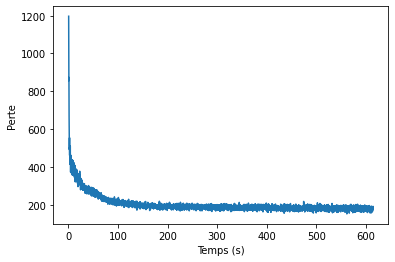

In [ ]:
plt.plot(time_l, loss_liste)
plt.xlabel('Temps (s)')
plt.ylabel('Perte')
plt.savefig('loss_fct_time.eps', dpi=200)
plt.show()

In [ ]:
reconst_images=deco.predict(np.random.normal(0,1,size=(3,2)))

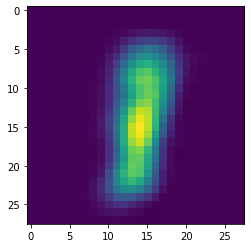

In [ ]:
img1=reconst_images[1]
img1=np.array(img1).reshape(28,28)
plt.imshow(img1)